密度モデル$(\rho : r/R_s [\rm{R_\odot}], n_e : [\rm{cm^{-3}}])$

* $1-10R_\odot \rightarrow n_e(\rho) = 10\times10^8 \times (2.99\rho^{-16} + 1.55\rho^{-6}) $ (10 $\times$ Baumbach-Allen model[Allen, 1947])

($n_e(\rho) = 10^8 \times (2.99\rho^{-16} + 1.55\rho^{-6} + 0.036r^{-\frac{3}{2}}) $ ([Baumbach, 1938]) )
* $10-65R_\odot \rightarrow n_e(\rho) = 6.14 \times (\rho - 1.0)^{-2.15\pm0.11}$ [Alverez & Haddock, 1973; Bougeret et al., 1984]
* $65-215R_\odot \rightarrow n_e(\rho) = 6.14 \times (\rho/215)^{-2.10}$ [Bougeret et al., 1984]


$ n_e(r,\phi) = F\times [ \frac{3.09\times10^8}{r^{16}}(1-0.5\sin{\phi}) + \frac{1.58\times 10^8}{r^6}(1-0.95\sin{\phi}) + \frac{2.51\times 10^6}{r^{2.5}}(1-(\sin{\phi})^{0.5})] $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp
from matplotlib.ticker import FixedLocator, MaxNLocator
from matplotlib.ticker import LogFormatter
import matplotlib.ticker as mticker

In [17]:


rho_value = np.arange(0.01, 20, 0.01)


# ----------------------- Density model -----------------------
# Baumbach-Allen model
def Baumbach(rho):
    return 1e8*(2.99*rho**(-16) + 1.55*rho**(-6) + 0.036*rho**(-3/2))

def Baumbach_Allen(rho):
    return 1e8*(2.99*rho**(-16) + 1.55*rho**(-6))

def Saito1970(rho, phi=0):
    # initial_latitude = 21
    # rho += 1.0 # 太陽中心からに換算
    sin_phi = np.sin(np.radians(phi))
    return (3.09e8 * (rho) ** -16 * (1 - 0.5 * sin_phi) +
            1.58e8 * rho ** -6 * (1 - 0.95 * sin_phi) +
            0.0251e8 * rho ** -2.5 * (1 - np.sqrt(sin_phi)))

def Vrsnak2004(rho):
    return 1e8 * (15.45 * rho ** -16 + 3.16 * rho ** -6 + 1 * rho ** -4 + 0.0033 * rho ** -2)


def Saito1977(rho):  # 2.5-5.5Rs
    C1 = [1.36e6, 5.27e4, 3.15e5]
    C2 = [1.68e8, 3.54e6, 1.60e6]
    d1 = [2.14, 3.30, 4.71]
    d2 = [6.13, 5.80, 3.01]
    
    background = C1[0]*rho**(-d1[0])+C2[0]*rho**(-d2[0])
    eq_hole = C1[1]*rho**(-d1[1])+C2[1]*rho**(-d2[1])
    pole_hole = C1[2]*rho**(-d1[2])+C2[2]*rho**(-d2[2])
    return background #, eq_hole, pole_hole


def Newkirk1961(rho):
    return 4.4e4*10**(4.32/rho)

def Wang2017(rho):
    maximum = -4.42158e6*rho**(-1)+5.41656e7*rho**(-2)+-1.86150e8*rho**(-3)+2.13102e8*rho**(-4)
    # minimum = 3.53766e5*rho**(-1)+1.03359e7*rho**(-2)+-5.46541e7*rho**(-3)+8.24791e7*rho**(-4)
    return maximum

def Kumari2017(rho): # 1.5-5.5Rs
    model = 1.521e8*rho**(-7.279)+1.84e8*rho**(-4.852)+7.52e5*rho**(-2.024)
    return model

def Leblanc1996(rho): # 1.8-215Rs
    model = 3.3e5*rho**(-2)+4.1e6*rho**(-4)+8.0e7*rho**(-6)
    return model


def Alvarez_and_Haddock1973(rho):  # 4.8-210Rs
    return 2.83e6*(rho-0.9)**(-2.15)
    

def Fainberg_and_Stone1971(rho):  # 10.0-40
    return 5.52e7*rho**(-2.63)


# モデルのリスト
density_models = [Saito1970, Newkirk1961]
# density_models = [Baumbach, Baumbach_Allen, Saito1970, Newkirk1961, Wang2017, Kumari2017, Leblanc1996]
# density_models = [Baumbach, Baumbach_Allen, Saito1970, Vrsnak2004, Saito1977, Newkirk1961, Wang2017, Kumari2017, Leblanc1996, Alvarez_and_Haddock1973, Fainberg_and_Stone1971]
# density_models = [Baumbach, Baumbach_Allen, Saito1970, Vrsnak2004]




In [4]:
# ----------------------- Frequency function -----------------------
# ----------------------- Frequency function -----------------------
# 周波数関数
def frequency_function(density_value):
    electron = 1.60217662e-19    # 電気素量：C
    m_e = 9.10938356e-31         # 電子の質量：kg
    epsilon_0 = 8.854187817e-12  # 真空の誘電率：F/m
    
    frequency_Hz = 1 / (2 * np.pi) * np.sqrt(electron ** 2 / (epsilon_0 * m_e)) * 1e3 * np.sqrt(density_value)
    frequency_MHz = frequency_Hz / 1e6
    return frequency_MHz

# 目的の周波数に対応するrhoを計算
def calculate_rho_from_frequency(frequency_MHz, density_model):
    rho = fsolve(lambda rho: frequency_function(rho, density_model) - frequency_MHz, x0=0.27)  # x0を浮動小数点に設定
    return rho[0]

## $n_e$のプロット

In [2]:
# # 電子密度neとrhoの関係をプロット
# def plot_function_ne(rho, label):
#     fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
#     ax.set_yscale('log') # 片対数グラフ
#     ax.set_xlabel(r'$\rho [R_\odot]$', fontsize=20) # x軸：rho[Rs]
#     ax.set_ylabel(r"$n_e[\rm{cm^{-3}}]$", fontsize=20) # y軸：ne[cm^-3]
#     ax.plot(rho, baumbach(rho), label=label)
    
    
#     # Find rho values corresponding to specific frequencies using fsolve
#     #周波数のプロットから先に計算しました
#     rho_40MHz = 2.07
#     rho_15MHz = 2.87
#     rho_300kHz = 10.57
    
    
#     # Set the y-axis limits in MHz
#     ax.set_ylim(baumbach(rho_300kHz), baumbach(rho_40MHz)) # y軸の範囲を設定. 300kHzから40MHzまで
#     ax.set_xlim(1.2, rho_300kHz+0.5) # x軸の範囲を設定. 40MHzから300kHz+0.5まで
#     ax.grid()
#     ax.axhline(y=baumbach(rho_15MHz), color='gray', linestyle='--', linewidth=0.8)
#     ax.axvline(x=rho_40MHz, color='gray', linestyle='--', linewidth=0.8)
#     ax.axvline(x=rho_15MHz, color='gray', linestyle='--', linewidth=0.8)

    
    # # Plot the text on the graph
    # # 40MHzに対応する電子密度
    # ax.text(rho_40MHz-3.0, baumbach(rho_40MHz), f'{baumbach(rho_40MHz):.2e}', fontsize=18)
    # ax.text(rho_40MHz-3.0, baumbach(rho_40MHz)-7e6, r'$(40\,\rm{MHz})$', fontsize=18)
    # # 15MHzに対応する電子密度
    # ax.text(rho_40MHz-3.0, baumbach(rho_15MHz), f'{baumbach(rho_15MHz):.2e}', fontsize=18)
    # ax.text(rho_40MHz-3.0, baumbach(rho_15MHz)-1.2e6, r'$(15\,\rm{MHz})$', fontsize=18)
    # # 300kHzに対応する電子密度
    # ax.text(rho_40MHz-3.0, baumbach(rho_300kHz), f'{baumbach(rho_40MHz):.2e}', fontsize=18)
    # ax.text(rho_40MHz-3.0, baumbach(rho_300kHz)-4e2, r'$(300\,\rm{kHz})$', fontsize=18)
    # # 最小のrho
    # ax.text(1.1, baumbach(rho_300kHz)-3.8e2, r'$1.20$', fontsize=18)    
    
    
    # # Plot points on the graph
    # # 40MHz，15MHz，300kHzの電子密度をプロット
    # ax.scatter([rho_40MHz, rho_15MHz, rho_300kHz], 
    #            [baumbach(rho_40MHz), baumbach(rho_15MHz), baumbach(rho_300kHz)], 
    #            color='red', marker='o', label='Specific Frequencies')
    
    # # Plot the text on the graph for rho values
    # #40MHzに対応するrhoの値をプロット
    # ax.text(rho_40MHz, baumbach(rho_300kHz)-0.7e3, f'{rho_40MHz:.2f}', fontsize=18, color='red')
    # # 矢印を描画
    # ax.annotate('',
    #             xy=(rho_40MHz, baumbach(rho_300kHz)), xycoords='data',
    #             xytext=(rho_40MHz+0.3, baumbach(rho_300kHz)-0.5e3), textcoords='data',
    #             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red')
    #             )
    # # 15MHzに対応するrhoの値をプロット
    # ax.text(rho_15MHz-0.3, baumbach(rho_300kHz)-0.4e3, f'{rho_15MHz:.2f}', fontsize=18, color='red')
    # # 300kHzに対応するrhoの値をプロット
    # ax.text(rho_300kHz-0.3, baumbach(rho_300kHz)-0.4e3, f'{rho_300kHz:.2f}', fontsize=18, color='red')
    # ax.legend(loc='best', fontsize=18)

In [3]:
# # 電子密度の関数をプロット
# plot_function_ne(rho_value, r'Baumbach 1938')
# plt.show()

## $f_p$のプロット

In [5]:
# 周波数とrhoの関係をプロット
def plot_function_frequency(rho, density_models):    
    # Find rho values corresponding to specific frequencies using fsolve
    rho_40MHz_list = []
    rho_14MHz_list = []
    
    for i in range(len(density_models)):
    #
        rho_40MHz = calculate_rho_from_frequency(40, density_models[i])
        rho_14MHz = calculate_rho_from_frequency(14, density_models[i])
        rho_40MHz_list.append(rho_40MHz)
        rho_14MHz_list.append(rho_14MHz)

    # ----------------- Plot the graph -----------------
    fig, ax = plt.subplots(tight_layout=True, figsize=(10,8))
    
    for i in range(len(density_models)):
        # グラフのプロット
        if callable(density_models[i]):
            ax.plot(
                rho, 
                frequency_function(rho, density_models[i]), 
                label=density_models[i].__name__  # 関数名をラベルに表示
            )
        # 縦線と点のプロット
        ax.axvline(x=rho_40MHz_list[i], color='gray', linestyle='--', linewidth=0.8)
        ax.scatter([rho_40MHz_list[i], rho_14MHz_list[i]], [40, 14], color=['blue', 'red'], marker='o')
        
        # rhoの値のテキスト表示
        ax.text(rho_40MHz_list[i]-0.05*i, 40, f'{rho_40MHz_list[i]:.2f}', fontsize=22, color='green')
        ax.text(rho_14MHz_list[i], 14, f'{rho_14MHz_list[i]:.2f}', fontsize=22, color='orange')
    
    # Plot the text on the graph
    # ax.text(np.min(rho_40MHz_list) - 0.15, 40.1, r'$40$', fontsize=18, color='green')
    ax.text(np.min(rho_40MHz_list) - 0.18, 14, r'$14\,\rm{MHz}$', fontsize=22, color='orange')
    
    ax.set_yscale('log')  # Set frequency axis to log scale
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):d}" if x >= 10 else ""))  # Modified for 2-digit integer labels
    ax.set_xlabel(r'$\rho [R_\odot]$', fontsize=18)
    ax.set_ylabel(r"Frequency [MHz] (Log)", fontsize=18)
    ax.grid(True, which="both", ls="--", color='gray')
    ax.legend(loc='best', fontsize=18)
    
    ax.set_title('Frequency vs. rho', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)


    # Set the y-axis limits in MHz
    ax.set_ylim(14, 40)
    ax.set_xlim(np.min(rho_40MHz_list) - 0.1, np.max(rho_14MHz_list) + 0.1)
    
    plt.show()


## 全密度モデル

ValueError: x and y must have same first dimension, but have shapes (1999,) and (1,)

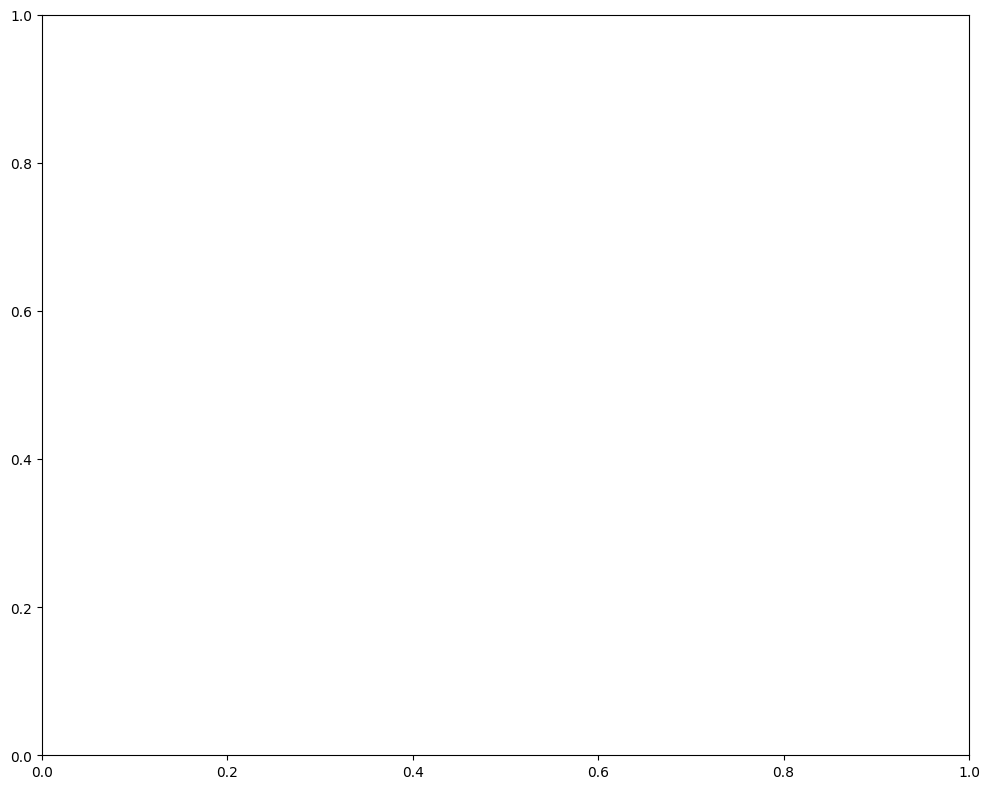

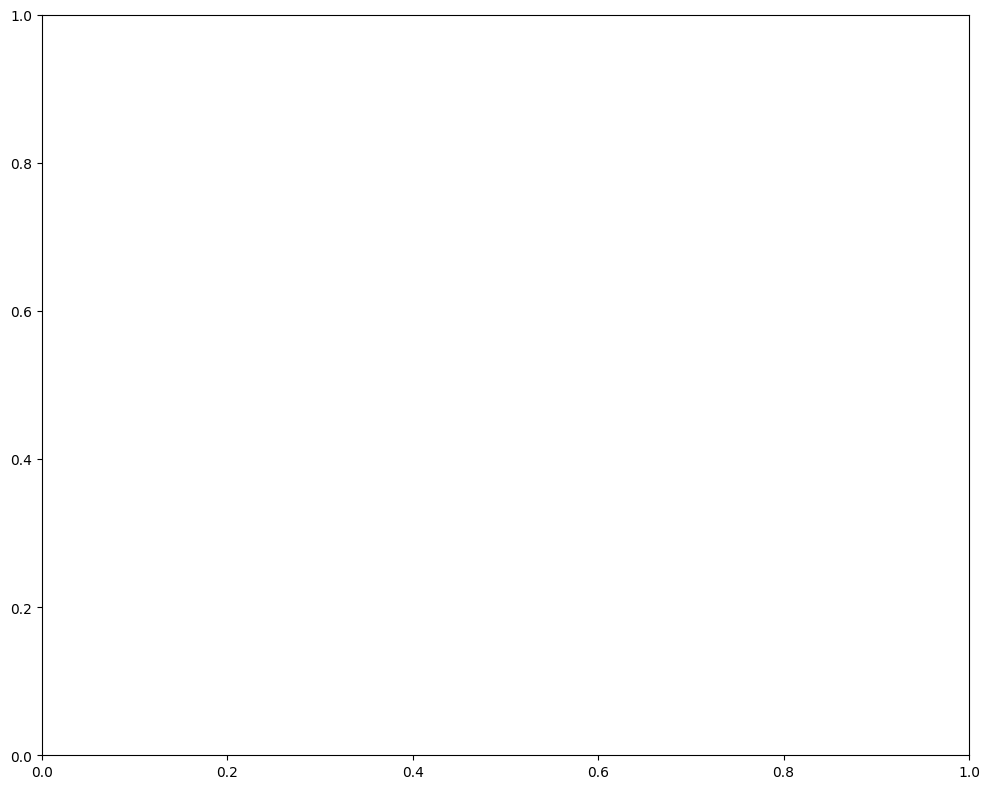

In [ ]:
# 角度 (phi) の設定
phi_values = np.arange(0, 105, 15)

# プロットの作成
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 8))

# for phi_value in phi_values:
#     density_values = Saito1970(rho_value, phi_value)  # **修正: 直接密度を計算**
#     # freq_values = frequency_function(density_values)  # **修正: density_value を直接渡す**
    
#     ax.plot(rho_value, density_values, label=f'$\phi={phi_value}\degree$')

ax.plot(rho_value, Saito1970(rho_value, 0), label=r'$\phi=0\degree$')
ax.plot(rho_value, Baumbach(rho_value), label='BaumBach 1938')
ax.plot(rho_value, Baumbach_Allen(rho_value), label='BaumBach-Allen 1946')
ax.plot(rho_value, Vrsnak2004(rho_value), label='Vrsnak 2004')
ax.plot(rho_value, Newkirk1961(rho_value), label='Newkirk 1961')
ax.plot(rho_value, Kumari2017(rho_value), label='Kumari 2017')
ax.plot(rho_value, Leblanc1996(rho_value), label='Leblanc 1996')
# ax.plot(rho_value, Alvarez_and_Haddock1973(rho_value), label='Alvarez and Haddock 1973')
ax.plot(rho_value, Fainberg_and_Stone1971(rho_value), label='Fainberg and Stone 1971')



# 軸設定
ax.set_yscale('log')
ax.set_xlabel(r'$\rho [R_\odot]$', fontsize=18)
ax.set_ylabel(r"$n_p \, [\mathrm{/cc}]$", fontsize=18)  # **単位を MHz に修正**
ax.set_title('Saito 1970', fontsize=20)
ax.set_xlim(0.01, 4)
ax.set_ylim(1e2, 1e18)
ax.grid()
ax.legend(title='Heliographical latitude', loc='best', fontsize=10)

# プロット表示
plt.show()

/tmp/ipykernel_89676/1311648397.py:37: RuntimeWarning: overflow encountered in power
  return 4.4e4*10**(4.32/rho)


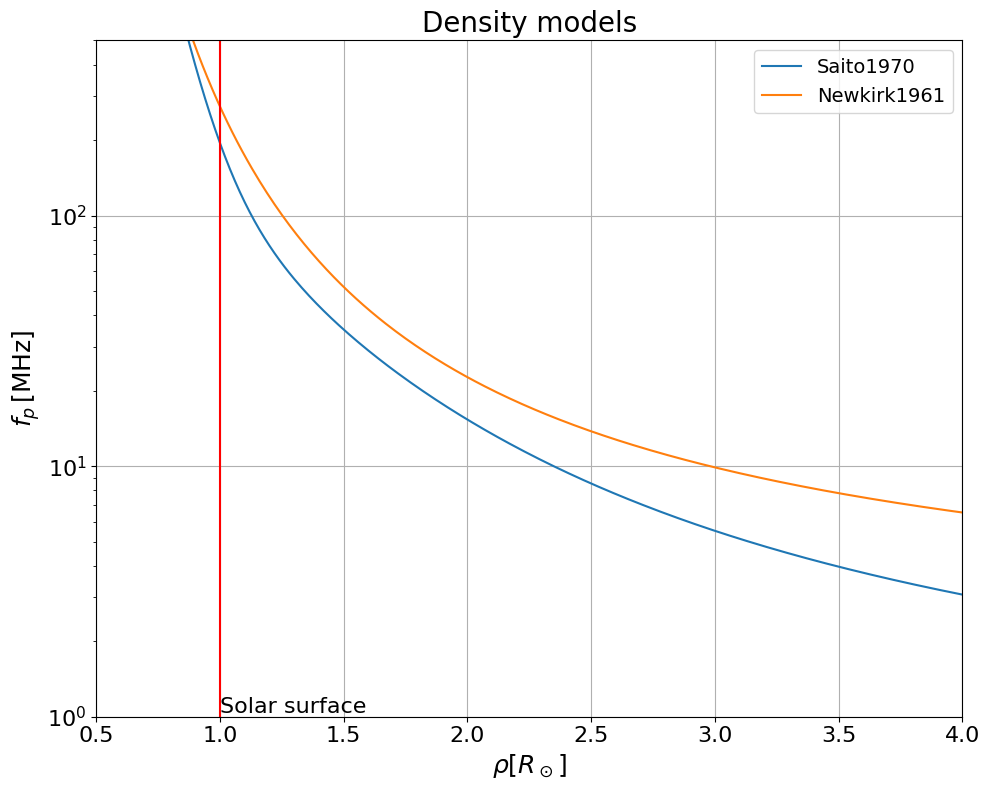

In [19]:
# 角度 (phi) の設定
phi_values = np.arange(0, 105, 15)

# プロットの作成
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 8))


for i in range(len(density_models)):
        # グラフのプロット
        if callable(density_models[i]):
            density_values = density_models[i](rho_value)  # **修正: 直接密度を計算**
            ax.plot(
                rho_value, 
                frequency_function(density_values), 
                label=density_models[i].__name__  # 関数名をラベルに表示
            )


xlim_min, xlim_max = 0.5, 4.0
ylim_min, ylim_max = 1, 500
ax.vlines(1.0, ylim_min, ylim_max, color='red', linewidth=1.5)
ax.text(1.0, ylim_min, 'Solar surface', va='bottom', ha='left', fontsize=16)

# 軸設定
ax.set_yscale('log')
ax.set_xlabel(r'$\rho [R_\odot]$', fontsize=18)
ax.set_ylabel(r"$f_p \, [\mathrm{MHz}]$", fontsize=18)  # **単位を MHz に修正**
ax.set_title('Density models', fontsize=20)
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()
ax.legend(loc='best', fontsize=14)

# プロット表示
plt.show()

## Saito1970

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_39722/3790161578.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(rho_value, density_values, label=f'$\phi={phi_value}\degree$')
/tmp/ipykernel_39722/3790161578.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(rho_value, density_values, label=f'$\phi={phi_value}\degree$')


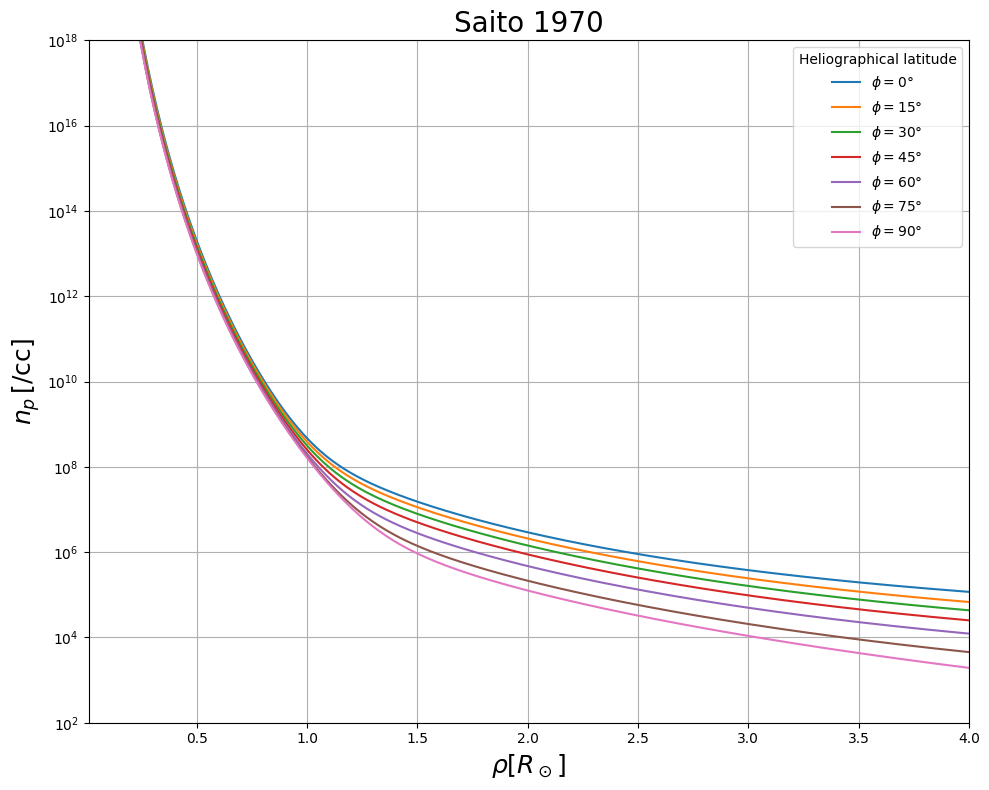

In [59]:
# 角度 (phi) の設定
phi_values = np.arange(0, 105, 15)

# プロットの作成
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 8))

for phi_value in phi_values:
    density_values = Saito1970(rho_value, phi_value)  # **修正: 直接密度を計算**
    freq_values = frequency_function(density_values)  # **修正: density_value を直接渡す**
    
    ax.plot(rho_value, density_values, label=f'$\phi={phi_value}\degree$')


# 軸設定
ax.set_yscale('log')
ax.set_xlabel(r'$\rho [R_\odot]$', fontsize=18)
ax.set_ylabel(r"$n_p \, [\mathrm{/cc}]$", fontsize=18)  # **単位を MHz に修正**
ax.set_title('Saito 1970', fontsize=20)
ax.set_xlim(0.01, 4)
ax.set_ylim(1e2, 1e18)
ax.grid()
ax.legend(title='Heliographical latitude', loc='best', fontsize=10)

# プロット表示
plt.show()

In [9]:
plot_function_frequency(rho_value, density_models)

TypeError: 'numpy.float64' object is not callable

## $\Delta v$の計算

読み取りmemo

2022年6月13日

- HF帯アンテナ

HF帯開始周波数：30MHz + 0.6(定規)　(＠03:24:20)

HF帯終了周波数：20MHz + 0.75(定規)　(＠03:33:00)

$\Delta t = $ 8min 40s = 520s

- Wind

Wind開始周波数：14MHz(＠03:31:00)

Wind終了周波数：1.8MHz(＠06:03:00)

$\Delta t = $ 2h 32min = 9120s

In [8]:
import numpy as np

# rho_nMHz : n MHzに対応するrhoの値を求める関数
def rho_nMHz(n):
    rho_nMHz_value = fsolve(lambda rho_value: frequency(rho_value) - n, x0=1.2)[0]
    print(f'rho_{n}MHz = {rho_nMHz_value:.2f}')
    return rho_nMHz_value




### start
# ダイナミックスペクトルを目分量で見て、startとendの周波数を決め，その周波数と時間に対応するrhoを求める
print('◎Enter the start frequency in MHz: ') # n × 10^7 Hz = n*10 MHz の部分．例：40 MHz -> 40
f_start = float(input())
print('f_start=' + str(f_start) + ' MHz')  # Convert f_start to a string using str()


# rho_start：start_frequencyに対応するrhoの値
print('rho_start =')
rho_start = rho_nMHz(f_start)

print('\n')





### end
# startと同様にendの周波数と時間に対応するrhoを求める
print('\n ◎Enter the end frequency in MHz: ')
f_end = float(input())
print('f_end=' + str(f_end) + ' MHz')  # Convert f_start to a string using str()

print('rho_end =')
rho_end = rho_nMHz(f_end)


print('\n')

# delta_rho : startとendのrhoの差
delta_rho = rho_end - rho_start
print(f'delta_rho = {delta_rho:.2f} R_\odot \n')



### delta_vを求める
# delta_f : startとendの周波数の差
delta_f = f_end - f_start
print(f'delta_f = {delta_f:.2f} MHz\n')

# delta_t : startとendの時間の差(目分量)
print('◎Enter the value of delta_t: ')
delta_t = float(input())
print(f'delta_t = {delta_t} s')

# dfdt : バースト源のドリフトレート[MHz/s]
dfdt = delta_f / delta_t
print('dfdt = ' + str(dfdt) + ' MHz/s')

# delta_v_R : バースト源の速度[R_sun/s]
delta_v_R = delta_rho / delta_t # R_\odot/s
R_sun = 696000 # km # 太陽半径 696,000 km
# delta_v_kms : バースト源の速度[km/s]
delta_v_kms = delta_v_R * R_sun # km/s 太陽半径：696,000 km
print('delta_v = ' + str(delta_v_R) + 'R_\odot /s = ' + str(delta_v_kms) + ' km/s')

print('v_b/1150=', delta_v_kms/1150)
print('1-220/v_b=', 1-220/delta_v_kms)

◎Enter the start frequency in MHz: 
f_start=100.0 MHz
rho_start =
rho_100.0MHz = 1.13



 ◎Enter the end frequency in MHz: 
f_end=10.0 MHz
rho_end =
rho_10.0MHz = 2.68


delta_rho = 1.55 R_\odot 

delta_f = -90.00 MHz

◎Enter the value of delta_t: 
delta_t = 900.0 s
dfdt = -0.1 MHz/s
delta_v = 0.0017256701145133106R_\odot /s = 1201.0663997012641 km/s
v_b/1150= 1.044405564957621
1-220/v_b= 0.8168294441883316
